# Preliminary Regression Analysis
During our hypothesis testing, we found that there was a signifcant difference between premium charges of smokers. We also found that same amount of premium were charged on both genders. We also look at the difference in premium charges across regions and found that the premium charges on southeast region was significantly different than the northeast region. In this notebook, we will identify the top factors that determines the premium insurance charges using linear regression model.

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn import set_config
set_config(transform_output = "pandas")

## Data Loading

In [3]:
DATASET_URI = "dataset/insurance.csv"
df0 = pd.read_csv(DATASET_URI)

df0.sample(n=10)

,age,sex,bmi,children,smoker,region,charges
860,37,female,47.60,2,yes,southwest,46113.5110
400,51,female,20.60,0,no,southwest,9264.7970
1305,24,female,27.72,0,no,southeast,2464.6188
1002,24,male,25.80,0,no,southwest,1972.9500
1197,41,male,33.55,0,no,southeast,5699.8375
684,33,female,18.50,1,no,southwest,4766.0220
327,45,male,36.48,2,yes,northwest,42760.5022
714,24,female,22.60,0,no,southwest,2457.5020
945,56,female,35.80,1,no,southwest,11674.1300
1102,29,male,38.94,1,no,southeast,3471.4096


## Data Splitting

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into feature matrix and target vector
X = df0.iloc[:, :-1]
y = df0.iloc[:, -1]

# Split the data into training, testing set, and evaluation set.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, test_size=0.2)
X_test, X_eval, y_test, y_eval = train_test_split(X, y, random_state=22, test_size=0.5)

## Building the ML Pipeline
The machine learning pipeline below defines all the steps of the data from feature pre-processing, feature selection, target variable preprocessing, and modelling.

In this pipeline, noticed that only the numeric variables `age`, and `bmi` were scaled. In addition, the polynomial features and interactions were only generated from this two variables.

In [5]:
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Define the ML pipeline
ml_pipeline = make_pipeline(
    # Conduct feature matrix preprocessing
    ColumnTransformer(
        [
            ("scaler", StandardScaler(), ["age", "bmi"]),
            ("passthrough", "passthrough", ["children"]),
            ("onehotencoder", OneHotEncoder(sparse_output=False, drop="first"), ["sex", "smoker", "region"])
        ]
    ),

    # Add interaction and polynomial terms on the continuous variables. Subject for hyper parameter tuning
    ColumnTransformer(
        [
            ("polynomial", PolynomialFeatures(), ["scaler__age", "scaler__bmi"])
        ],
        remainder="passthrough"
    ),
    
    # Conduct target vector preprocessing then regression modelling
    TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log,
        inverse_func=np.exp
    )
)

## Cross Validation
In our ML pipeline, we define a `PolynomialFeature` step. But as of the moment, we don't know for sure what is the best value of `degree` to use; should we use interaction terms? should we add bias? The code section below will show how to figure this out automatically using Grid Search.

In [6]:
from warnings import filterwarnings
filterwarnings(action="ignore", category=UserWarning)

In [7]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit

param_grid = {
    # Hyerparameters for Polynomial and Interaction Feature Generation
    'columntransformer-2__polynomial__degree': [1,2,3,4,5],
    'columntransformer-2__polynomial__include_bias': [False, True],
    'columntransformer-2__polynomial__interaction_only': [False, True],
}

shuffle_splitter = ShuffleSplit(n_splits=10, test_size=0.2, random_state=22)

grid_searcher = GridSearchCV(
    estimator=ml_pipeline,
    param_grid=param_grid,
    cv=shuffle_splitter,
    scoring="explained_variance"
)

grid_searcher.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=22, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('columntransformer-1',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['children']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       (...
                                       ('transformedtargetregressor',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=LinearRegression()))]),
             param_grid={'columntransformer-2__polynomial__degree': [1, 2, 3, 4,
                                                                     5],
                         'columntransformer-2__polynomial__include_bias': [False,
                                                                           True],
                         'columntransformer-2__polynomial__interaction_only': [False,
                                                                               True]},
             scoring='explained_variance')

### Grid Search Results

In [8]:
pd.DataFrame(grid_searcher.cv_results_).sort_values(by=["rank_test_score"]).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer-2__polynomial__degree,param_columntransformer-2__polynomial__include_bias,param_columntransformer-2__polynomial__interaction_only,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
12,0.033807,0.013330,0.019954,0.005669,4,False,False,"{'columntransformer-2__polynomial__degree': 4,...",0.568271,0.501721,...,0.517339,0.640908,0.490407,0.579815,0.606629,0.538084,0.494098,0.559973,0.058788,1
14,0.021752,0.002359,0.012203,0.000843,4,True,False,"{'columntransformer-2__polynomial__degree': 4,...",0.568271,0.501721,...,0.517339,0.640908,0.490407,0.579815,0.606629,0.538084,0.494098,0.559973,0.058788,2
8,0.019401,0.000488,0.011852,0.000390,3,False,False,"{'columntransformer-2__polynomial__degree': 3,...",0.551195,0.511795,...,0.532376,0.627830,0.476232,0.557130,0.616702,0.533855,0.502339,0.557195,0.056957,3
10,0.019500,0.000499,0.011702,0.000459,3,True,False,"{'columntransformer-2__polynomial__degree': 3,...",0.551195,0.511795,...,0.532376,0.627830,0.476232,0.557130,0.616702,0.533855,0.502339,0.557195,0.056957,3
6,0.020107,0.001306,0.012299,0.001100,2,True,False,"{'columntransformer-2__polynomial__degree': 2,...",0.573052,0.510892,...,0.518588,0.630168,0.464852,0.570944,0.611699,0.535194,0.492024,0.556584,0.059894,5


### Best Hyperparameters

In [9]:
pd.DataFrame({
    "Hyper-parameter": grid_searcher.best_params_.keys(),
    "Values": grid_searcher.best_params_.values(),
})

,Hyper-parameter,Values
0,columntransformer-2__polynomial__degree,4
1,columntransformer-2__polynomial__include_bias,False
2,columntransformer-2__polynomial__interaction_only,False


### Best Model

In [10]:
best_model = grid_searcher.best_estimator_
best_model

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['age', 'bmi']),
                                                 ('passthrough', 'passthrough',
                                                  ['children']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('columntransformer-2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('polynomial',
                                                  PolynomialFeatures(degree=4,
                                                                     include_bias=False),
                                                  ['scaler__age',
                                                   'scaler__bmi'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

Based on the results of our grid search, the best model should have no bias, should have a degree of 4, and should include interaction terms.

## Features Received

In [11]:
pd.Series(best_model[:2].get_feature_names_out())

0                        polynomial__scaler__age
1                        polynomial__scaler__bmi
2                      polynomial__scaler__age^2
3            polynomial__scaler__age scaler__bmi
4                      polynomial__scaler__bmi^2
5                      polynomial__scaler__age^3
6          polynomial__scaler__age^2 scaler__bmi
7          polynomial__scaler__age scaler__bmi^2
8                      polynomial__scaler__bmi^3
9                      polynomial__scaler__age^4
10         polynomial__scaler__age^3 scaler__bmi
11       polynomial__scaler__age^2 scaler__bmi^2
12         polynomial__scaler__age scaler__bmi^3
13                     polynomial__scaler__bmi^4
14              remainder__passthrough__children
15            remainder__onehotencoder__sex_male
16          remainder__onehotencoder__smoker_yes
17    remainder__onehotencoder__region_northwest
18    remainder__onehotencoder__region_southeast
19    remainder__onehotencoder__region_southwest
dtype: object

## Feature Importance

In [12]:
feature_importance = pd.Series(
    data=best_model.named_steps['transformedtargetregressor'].regressor_.coef_,
    index=best_model.named_steps['transformedtargetregressor'].feature_names_in_
).sort_values(ascending=False)

feature_importance

remainder__onehotencoder__smoker_yes          1.547634
polynomial__scaler__age                       0.394020
polynomial__scaler__age^2                     0.109340
polynomial__scaler__bmi                       0.094157
remainder__passthrough__children              0.090885
polynomial__scaler__age^3                     0.053604
polynomial__scaler__age scaler__bmi^2         0.013034
polynomial__scaler__age^2 scaler__bmi         0.010136
polynomial__scaler__age^2 scaler__bmi^2       0.007722
polynomial__scaler__age scaler__bmi^3         0.001513
polynomial__scaler__bmi^4                    -0.002344
polynomial__scaler__bmi^3                    -0.003415
polynomial__scaler__age^3 scaler__bmi        -0.009027
polynomial__scaler__age scaler__bmi          -0.017034
polynomial__scaler__bmi^2                    -0.017721
remainder__onehotencoder__region_northwest   -0.066283
polynomial__scaler__age^4                    -0.070185
remainder__onehotencoder__sex_male           -0.072272
remainder_

<Axes: title={'center': 'Feature Importance'}>

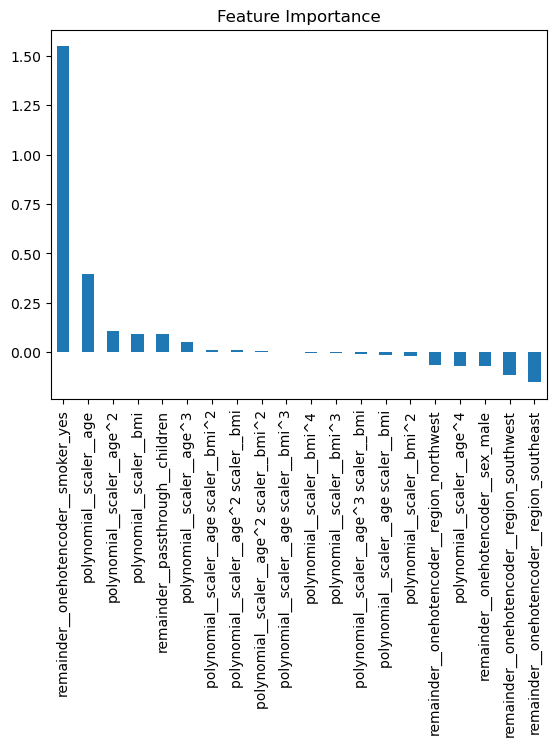

In [13]:
feature_importance.plot(kind="bar", title="Feature Importance")

Based on the above visualization, the top 2 factors affecting the premium charges were `smoker`, `age`. 
The charges of smokers were 4.66 times higher than non-smokers. In addition, premium charge was directly proportianal with `age`.

## Residuals

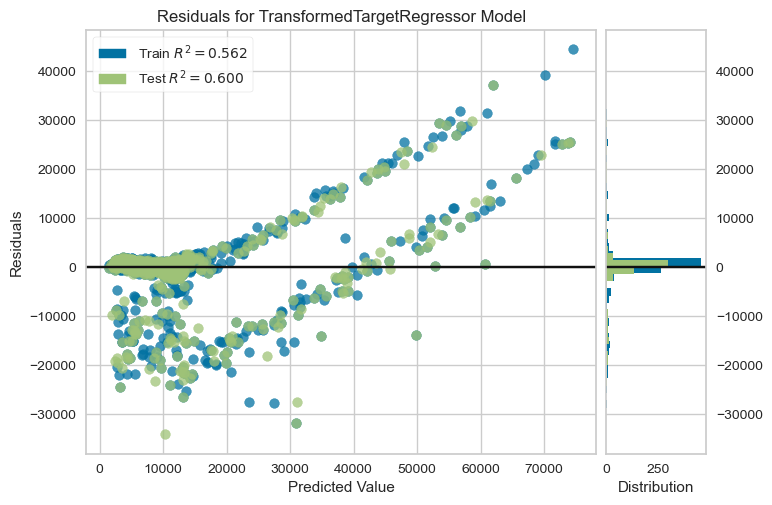

In [14]:
from yellowbrick.regressor import ResidualsPlot, PredictionError

residuals_plot = ResidualsPlot(estimator=best_model)
residuals_plot.fit(X_train, y_train)
residuals_plot.score(X_eval, y_eval)
residuals_plot.show();

Above residual plot shows that the error on our linear model starts to linearly increases with predicted value as the predicted value reaches $20,000.00 and higher. Since the error is not normally distributed, we cannot accurately make good inference with our data.

## Prediction Error

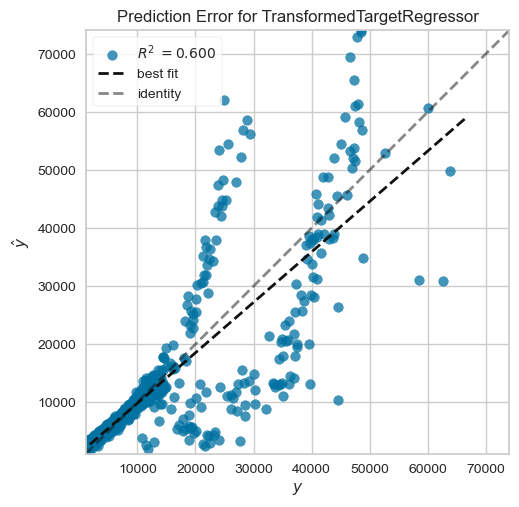

In [15]:
prediction_error_plot = PredictionError(estimator=best_model)
prediction_error_plot.fit(X_train, y_train)
prediction_error_plot.score(X_eval, y_eval)
prediction_error_plot.show();

The above prediction plot shows that our linear model's prediction were close to the actual values when the premium charges were less than $20,000.00. However as the premium charge increases above the 20,000.00 mark, our linear model's prediction were not accurate anymore.

## Model Evaluation

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Generate predictions using the training and evaluation data
y_train_pred = best_model.predict(X_train)
y_eval_pred = best_model.predict(X_eval)

# Calculate the metrics
metric_names = [metric.__name__ for metric in [mean_absolute_error, mean_squared_error, r2_score]]
training_metric_values = [metric(y_train, y_train_pred) for metric in [mean_absolute_error, mean_squared_error, r2_score]]
eval_metric_values = [metric(y_eval, y_eval_pred) for metric in [mean_absolute_error, mean_squared_error, r2_score]]

# Present the metrics in a dataframe
model_metrics_summary = pd.DataFrame({
    "Training Score": training_metric_values,
    "Cross-validation Score": eval_metric_values,
}, index=metric_names)

In [17]:
pd.options.display.float_format = '{:,.2f}'.format
model_metrics_summary["Score Difference"] = model_metrics_summary["Cross-validation Score"] - model_metrics_summary["Training Score"]
model_metrics_summary

,Training Score,Cross-validation Score,Score Difference
mean_absolute_error,"4,132.67","4,142.28",9.61
mean_squared_error,"64,062,672.18","62,969,730.55","-1,092,941.64"
r2_score,0.56,0.60,0.04


## Conclusions

In this notebook, we performed machine learning modelling using multiple linear regression using an ML pipeline. In this pipeline, we streamlined the data preprocessing stage, polynomial feature generation, and linear regression modelling. We conducted grid search on our polynomial feature generator stage and found that the optimal degree of features was 4. The model performs optimally when it uses interaction terms and without bias terms.

The linear model's metrics shows that our model's training and cross validation score were close to each other. This indicates that our model's performance generalizes well on unseen data.
However, the mean absolute error of our model shows that for both training and cross validation data, the model's prediction were off by $\$4000.00$. In addition, the model's $R^2$ statistic shows that it can only explain 60% of the variance of our dataset. These two are evidence that our model suffers from a high bias.

Given that the residual plot of our model does not exhibit a normally distributed data centered at $0$, we cannot give an accurate inference about the effects of each predictor on premium charges.

All in all, the linear model do helped us identify the key factos driving premium charges. The top features affecting the premium charges were `smoker`, sum of `age` and `age^2`, `bmi`, and `children`. Since our model's residuals does not exhibit a normally distributed data centered at 0, we cannot make an accurate inference about the data. If we desire to quantify the imact of features on premium charges, it is advisable to use an alternative interpretable ML model like decision tree.